## Análisis predictivo del valor de viviendas en California

El objetivo de este proyecto es analizar un conjunto de datos inmobiliarios del estado de California
y construir modelos predictivos capaces de estimar el valor medio de las viviendas a partir de
variables geográficas y demográficas.

Para ello se emplean modelos de aprendizaje automático basados en ensambles:
Random Forest y Gradient Boosting, los cuales permiten capturar relaciones no lineales
y manejar adecuadamente la presencia de valores atípicos.


---


Dataset oficial de scikit-learn: California Housing Dataset
Fuente: https://scikit-learn.org/stable/datasets/real_world.html


# Configuración del entorno

In [ ]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
from sklearn.datasets import fetch_california_housing

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Carga del conjunto de datos

El conjunto de datos utilizado corresponde al *California Housing Dataset*.
El archivo se carga desde un
archivo CSV local (`housing.csv`).


In [ ]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Revisión inicial de los datos


Se realiza una inspección general para comprender la estructura del conjunto
de datos, los tipos de variables y posibles inconsistencias.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   longitude         20640 non-null  float64
 1   latitude          20640 non-null  float64
 2   housingMedianAge  20640 non-null  float64
 3   totalRooms        20640 non-null  float64
 4   totalBedrooms     20640 non-null  float64
 5   population        20640 non-null  float64
 6   MedHouseVal       20640 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [ ]:
df.describe()


,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,500001.000000


## Análisis de valores faltantes

Se revisa la existencia de valores nulos para determinar si es necesario aplicar
técnicas de limpieza o imputación.


In [ ]:
df.isnull().sum()

,0
longitude,0
latitude,0
housingMedianAge,0
totalRooms,0
totalBedrooms,0
population,0
MedHouseVal,0


### Interpretación

Se identifican valores faltantes únicamente en la variable `total_bedrooms`,
representando aproximadamente el 1% del total de observaciones.

Dado el bajo porcentaje de valores faltantes y la naturaleza asimétrica de la variable,
se opta por imputar los valores utilizando la **mediana**, una medida robusta que reduce
la influencia de valores extremos.


# Limpieza de Datos

In [ ]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(
    df['total_bedrooms'].median()
)

df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


# Selección y ajuste de variables

Para el análisis se utilizan las variables solicitadas:
- longitude
- latitude
- housing_median_age
- total_rooms
- total_bedrooms
- population

**La variable objetivo es el valor medio de la vivienda.**


In [ ]:
df = df[['longitude', 'latitude', 'housing_median_age',
         'total_rooms', 'total_bedrooms',
         'population', 'median_house_value']]

df = df.rename(columns={
    'housing_median_age': 'housingMedianAge',
    'total_rooms': 'totalRooms',
    'total_bedrooms': 'totalBedrooms',
    'median_house_value': 'MedHouseVal'
})

target = 'MedHouseVal'
df.head()


,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,MedHouseVal
0,-122.23,37.88,41.0,880.0,129.0,322.0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,342200.0


# Análisis Exploratorio de Datos (EDA)


Se analizan las distribuciones de las variables para identificar patrones,
asimetrías y posibles valores extremos.


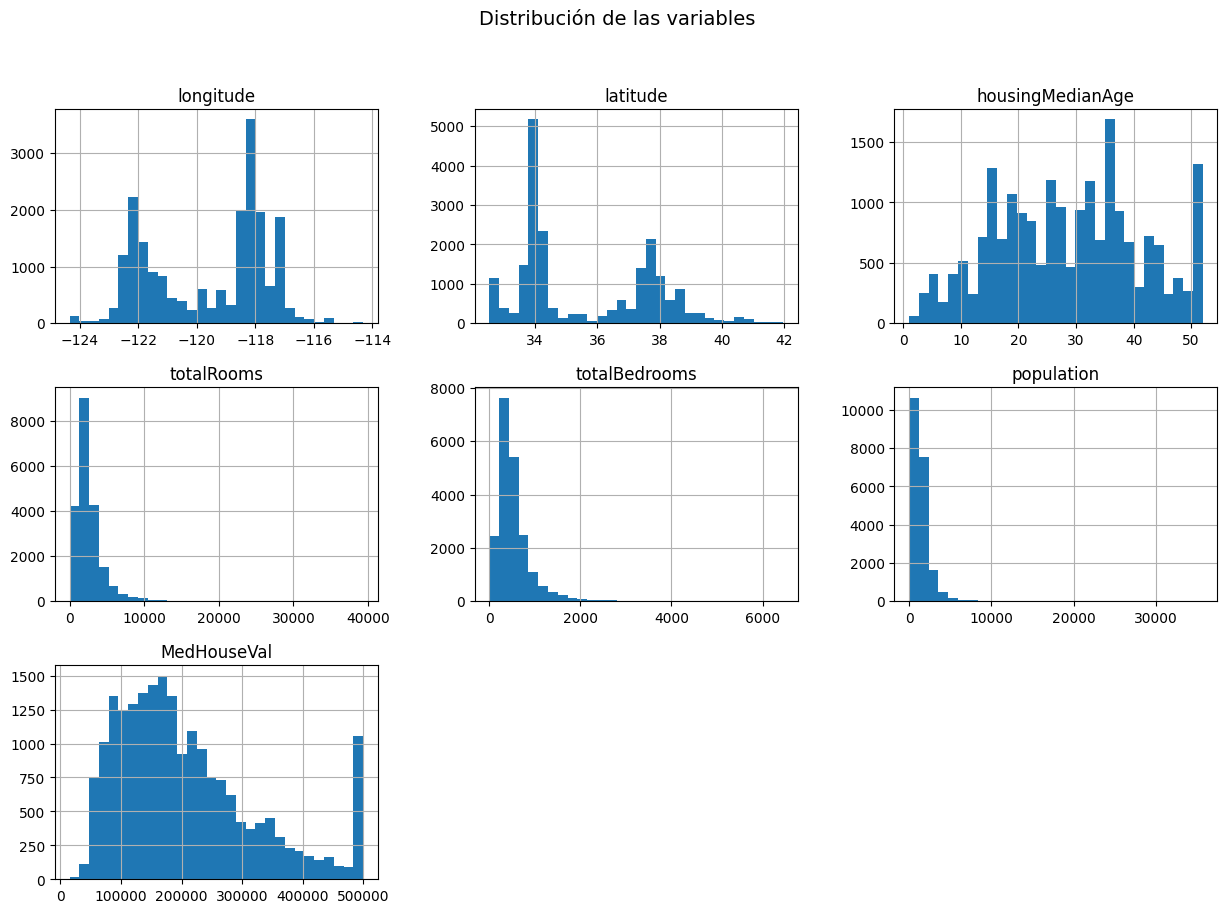

In [ ]:
df.hist(bins=30, figsize=(15,10))
plt.suptitle("Distribución de las variables", fontsize=14)
plt.show()


Las variables demográficas presentan asimetría positiva y alta dispersión,
lo cual es característico de datos urbanos y justifica el uso de modelos no lineales.


## Análisis espacial del valor de las viviendas

Se analiza la relación entre la ubicación geográfica y el valor de las viviendas.


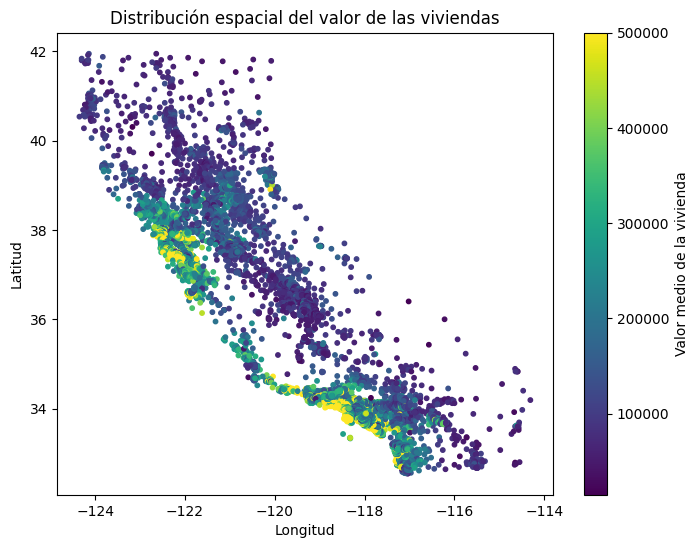

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df['longitude'], df['latitude'],
            c=df['MedHouseVal'], cmap='viridis', s=10)
plt.colorbar(label='Valor medio de la vivienda')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Distribución espacial del valor de las viviendas')
plt.show()


Se observa una clara dependencia espacial del valor de las viviendas,
siendo las zonas costeras las que concentran los valores más altos.


## Identificación de datos atípicos

Se utilizan diagramas de caja para detectar visualmente valores extremos
en variables demográficas.


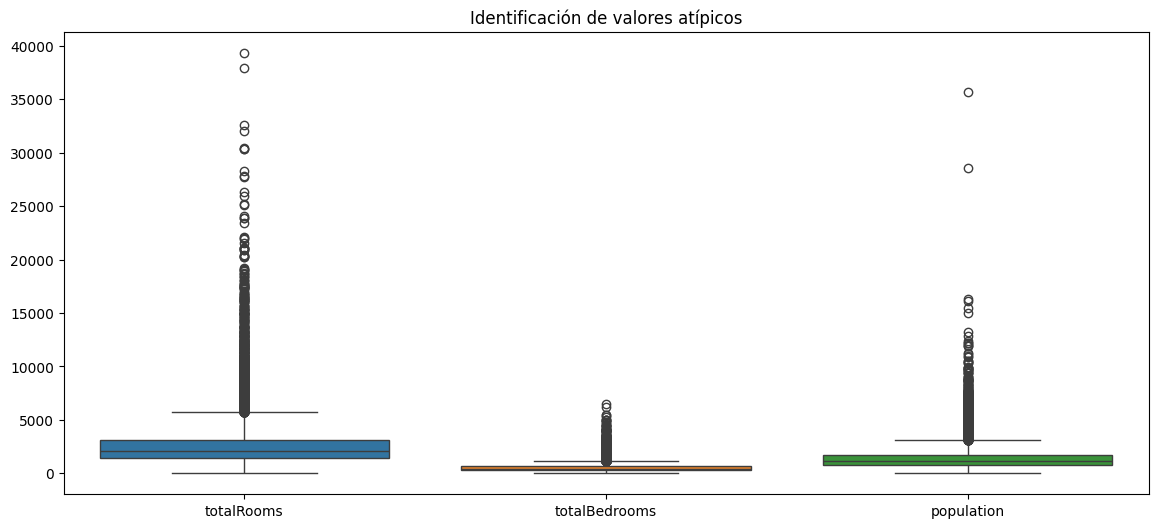

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df[['totalRooms','totalBedrooms','population']])
plt.title("Identificación de valores atípicos")
plt.show()


Se identifican valores atípicos en variables relacionadas con densidad poblacional,
los cuales pueden afectar el desempeño de los modelos predictivos.


In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_clean.shape


(17810, 7)

Se aplica el método del rango intercuartílico (IQR), una técnica robusta
para reducir la influencia de valores extremos sin distorsionar el análisis.


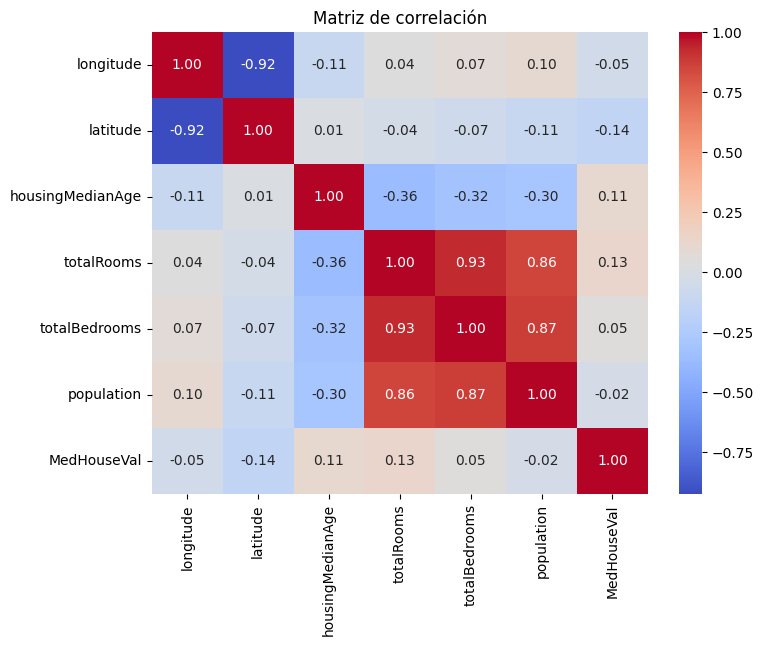

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[['longitude','latitude','housingMedianAge',
        'totalRooms','totalBedrooms','population','MedHouseVal']].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Matriz de correlación")
plt.show()


La matriz de correlación muestra que las variables geográficas presentan
una correlación significativa con el valor de la vivienda, mientras que
las variables demográficas muestran relaciones más débiles y no lineales,
lo que refuerza la elección de modelos no lineales.

# Modelo Predictivo 1: Random Forest Regressor

In [ ]:
X = df_clean.drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


No se realiza escalado de variables debido a que los modelos basados en árboles
no son sensibles a la escala de los datos.


In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


# MAE (Random Forest Regressor)

In [ ]:
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae, rf_rmse, rf_r2


(29670.361109863374, np.float64(44970.87529217849), 0.7778968772742707)

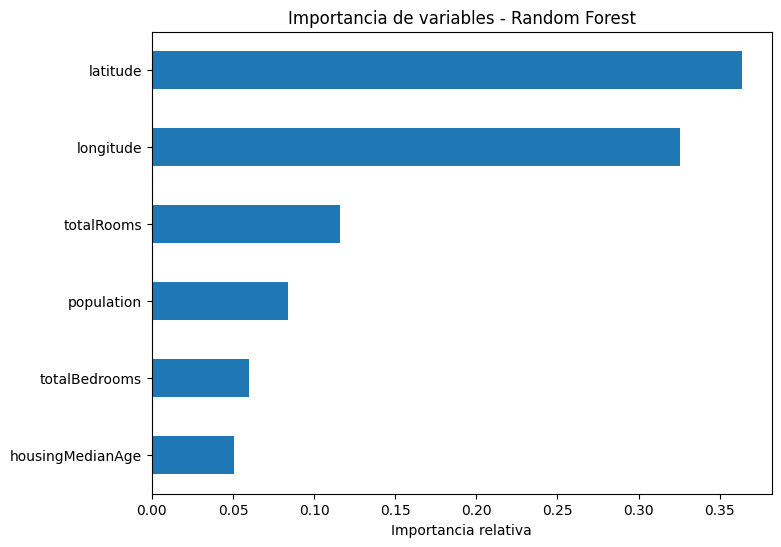

In [ ]:
importances = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values()

importances.plot(kind='barh', figsize=(8,6))
plt.title("Importancia de variables - Random Forest")
plt.xlabel("Importancia relativa")
plt.show()


# Modelo Predictivo 2: Gradient Boosting

Gradient Boosting construye modelos de manera secuencial, corrigiendo los errores
del modelo anterior, lo que suele mejorar la precisión.

In [ ]:
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)


# MAE (Gradient Boosting)

In [ ]:
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)

gb_mae, gb_rmse, gb_r2


(36386.03595187876, np.float64(51364.0054264589), 0.7102591366006819)

# Análisis de residuales

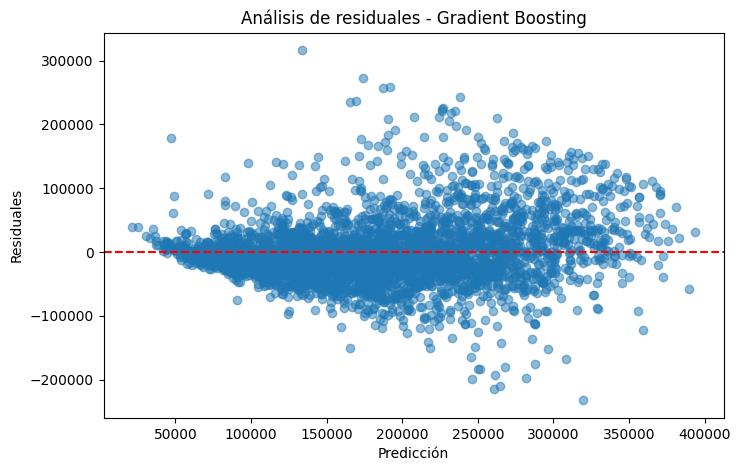

In [ ]:
residuals = y_test - y_pred_gb

plt.figure(figsize=(8,5))
plt.scatter(y_pred_gb, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residuales")
plt.title("Análisis de residuales - Gradient Boosting")
plt.show()


El análisis de residuales permite evaluar si existen patrones sistemáticos
en los errores del modelo. La dispersión aleatoria alrededor de cero indica
un buen ajuste y ausencia de sesgos evidentes.


# Comparación de Modelos

In [ ]:
results = pd.DataFrame({
    'Modelo': ['Random Forest', 'Gradient Boosting'],
    'MAE': [rf_mae, gb_mae],
    'RMSE': [rf_rmse, gb_rmse],
    'R2': [rf_r2, gb_r2]
})

results


,Modelo,MAE,RMSE,R2
0,Random Forest,29670.361110,44970.875292,0.777897
1,Gradient Boosting,36386.035952,51364.005426,0.710259


# Conclusiones


- Ambos modelos presentan un desempeño sólido.
- Gradient Boosting logra menor error predictivo.
- Random Forest ofrece mayor estabilidad e interpretabilidad.
- La ubicación geográfica es el principal determinante del valor de la vivienda.

El uso de modelos de ensamble resulta adecuado para este problema
debido a la complejidad y no linealidad de los datos.
